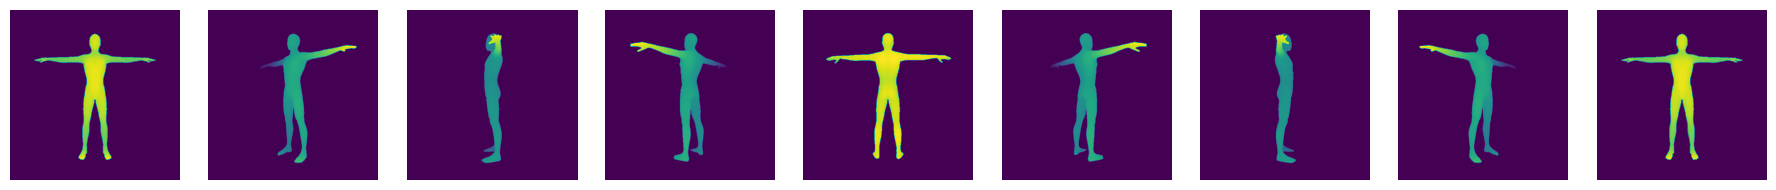

In [2]:
%load_ext autoreload
%autoreload 2

from text3d2video.artifacts.anim_artifact import AnimationArtifact
from text3d2video.ipython_utils import display_ims
from text3d2video.rendering import render_depth_map
import torch


torch.set_grad_enabled(False)

animation_tag = 'mixamo-human_rotation:latest'
animation = AnimationArtifact.from_wandb_artifact_tag(animation_tag)

verts_uvs, faces_uvs = animation.uv_data()

n_frames = 9
frame_indices = animation.frame_indices(9)
cameras, meshes = animation.load_frames(frame_indices)

depths = render_depth_map(meshes, cameras)
display_ims(depths)

In [5]:
from text3d2video.util import project_visible_texels_to_cameras_batched

texture_res = 100
frame_xy_coords, frame_uv_coords = project_visible_texels_to_cameras_batched(
    meshes,
    cameras,
    verts_uvs,
    faces_uvs,
    texture_res=texture_res,
    render_resolution=5000,
)

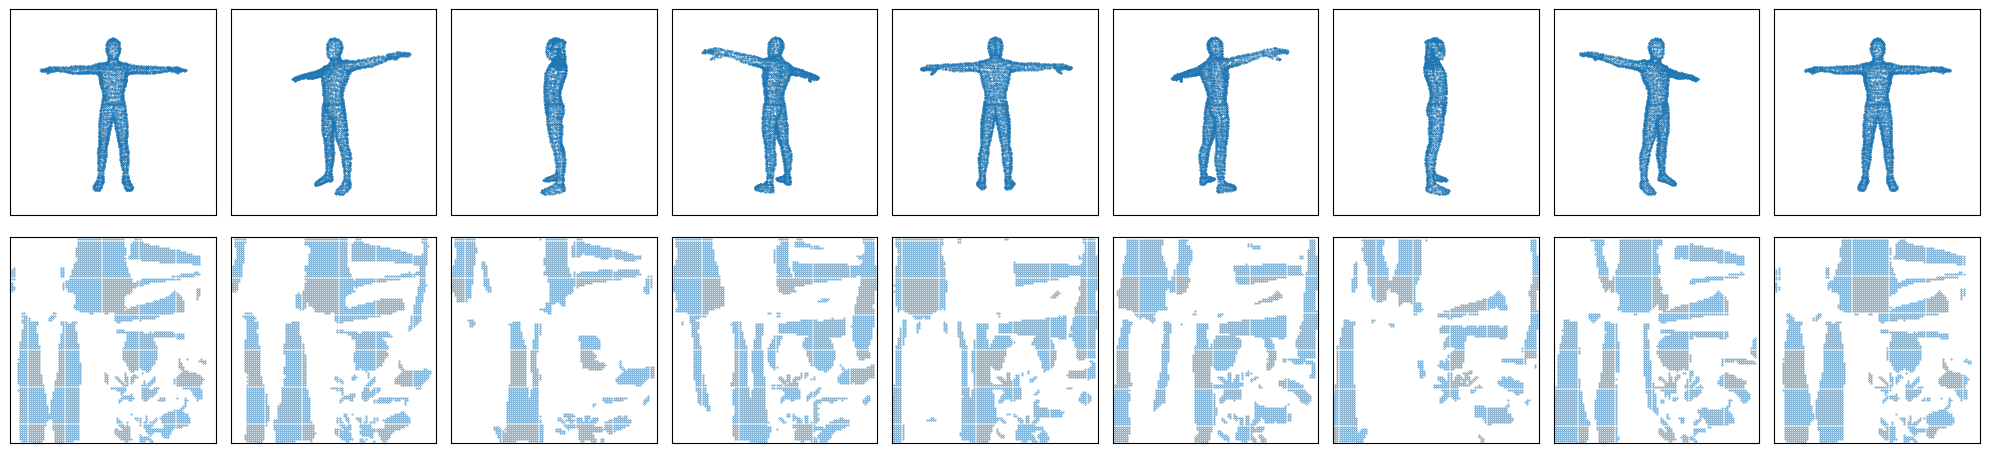

In [6]:
from matplotlib import pyplot as plt

s = 0.1

fig, axs = plt.subplots(2, len(frame_xy_coords), figsize=(20, 5))
for i, (xy_coords, uv_coords) in enumerate(zip(frame_xy_coords, frame_uv_coords)):
    ax_cam = axs[0, i]
    ax_uv = axs[1, i]

    ax_cam.scatter(xy_coords[:, 0].cpu(), xy_coords[:, 1].cpu(), s=s)

    ax_uv.scatter(uv_coords[:, 0].cpu(), uv_coords[:, 1].cpu(), s=s)

    ax_uv.set_aspect("equal")
    ax_uv.set_xlim(0, texture_res)
    ax_uv.set_ylim(0, texture_res)

    ax_cam.set_xlim(-1, 1)
    ax_cam.set_ylim(-1, 1)
    ax_cam.set_aspect("equal")

    ax_uv.set_xticks([])
    ax_uv.set_yticks([])
    ax_cam.set_xticks([])
    ax_cam.set_yticks([])

plt.tight_layout()

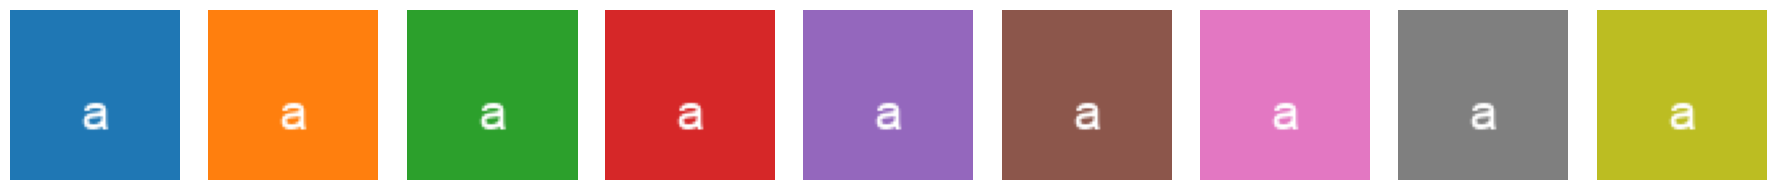

In [7]:
from matplotlib.cm import get_cmap
import torchvision.transforms.functional as TF
from visual_tests.testing_utils import test_img

CAMERA_RES = 64

cmap = get_cmap("tab10")

indices = torch.arange(n_frames)
colors = cmap(indices)

images = [
    test_img(resolution=CAMERA_RES, color=colors[i][0:3], txt="a")
    for i in range(n_frames)
]
feature_maps = torch.stack([TF.to_tensor(img) for img in images])

display_ims(images)

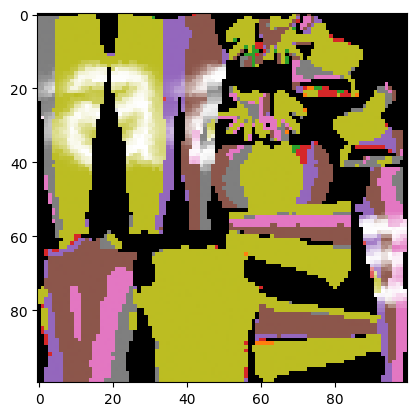

In [8]:
# frame_xy_coords
# frame_uv_coords

from text3d2video.util import aggregate_feature_maps

uv_map = aggregate_feature_maps(
    feature_maps.cuda(),
    texture_res,
    frame_xy_coords,
    frame_uv_coords,
    interpolation_mode='bilinear' 
)

plt.imshow(uv_map.cpu())

In [10]:
import torchvision.transforms.functional as TF
from pytorch3d.renderer import TexturesUV
from text3d2video.util import render_multiview
from text3d2video.video_util import pil_frames_to_clip

mesh = meshes[0]
mesh.textures = TexturesUV(
    maps=uv_map.unsqueeze(0),
    verts_uvs=verts_uvs.unsqueeze(0),
    faces_uvs=faces_uvs.unsqueeze(0),
)

frames = render_multiview(mesh, resolution=CAMERA_RES)
pil_frames_to_clip(frames).ipython_display()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
